**1. Importing required Library**

In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGE = True

Using TensorFlow backend.


**2. Define some constant needed throughout the script**

In [5]:
N_CLASSES = 10
EPOCHS = 15
PATIENCE = 5
TRAIN_PATH= 'datasets\\monki\\training\\'
VALID_PATH = 'datasets\\monki\\validation\\'
MODEL_CHECK_WEIGHT_NAME = 'resnet_monki_v1_chk.h5'

**3. Define model to be used**
we freeze the pre trained resnet model weight, and add few layer on top of it to utilize our custom dataset


In [3]:
K.set_learning_phase(0)
model = ResNet50(input_shape=(224,224,3),include_top=False, weights=None, pooling='avg')
K.set_learning_phase(1)
x = model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASSES, activation='softmax', name='custom_output')(x)
custom_resnet = Model(inputs=model.input, outputs = output)

for layer in model.layers:
    layer.trainable = False

custom_resnet.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
custom_resnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 47s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
______________________________________________________

**4. Load dataset to be used**

In [6]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
traingen = datagen.flow_from_directory(TRAIN_PATH, target_size=(224,224), batch_size=32, class_mode='categorical')
validgen = datagen.flow_from_directory(VALID_PATH, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=False)

Found 1097 images belonging to 10 classes.
Found 137 images belonging to 10 classes.


**5. Train Model**
we use ModelCheckpoint to save the best model based on validation accuracy


In [7]:
es_callback = EarlyStopping(monitor='val_acc', patience=PATIENCE, mode='max')
mc_callback = ModelCheckpoint(filepath=MODEL_CHECK_WEIGHT_NAME, monitor='val_acc', save_best_only=True, mode='max')
train_history = custom_resnet.fit_generator(traingen, steps_per_epoch=len(traingen), epochs= EPOCHS, validation_data=validgen, validation_steps=len(validgen), verbose=2, callbacks=[])


Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 42s - loss: 1.2631 - acc: 0.5998 - val_loss: 0.4928 - val_acc: 0.8394
Epoch 2/15
 - 24s - loss: 0.2474 - acc: 0.9321 - val_loss: 0.1572 - val_acc: 0.9489
Epoch 3/15
 - 36s - loss: 0.1164 - acc: 0.9652 - val_loss: 0.0670 - val_acc: 0.9781
Epoch 4/15
 - 36s - loss: 0.1149 - acc: 0.9598 - val_loss: 0.1376 - val_acc: 0.9635
Epoch 5/15
 - 34s - loss: 0.0880 - acc: 0.9705 - val_loss: 0.0729 - val_acc: 0.9708
Epoch 6/15
 - 30s - loss: 0.0695 - acc: 0.9750 - val_loss: 0.1253 - val_acc: 0.9489
Epoch 7/15
 - 30s - loss: 0.0646 - acc: 0.9768 - val_loss: 0.1033 - val_acc: 0.9562
Epoch 8/15
 - 30s - loss: 0.0421 - acc: 0.9830 - val_loss: 0.1333 - val_acc: 0.9562


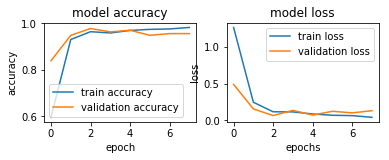

In [8]:
plt.figure(1)
plt.subplot(221)
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy','validation accuracy'])

plt.subplot(222)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'])

plt.show()

**7. Load Last Checkpoint Weight**

In [9]:
#custom_resnet.load_weights(MODEL_CHECK_WEIGHT_NAME)

**7. Print validation confusion matrix, classification report, and accuracy**

In [10]:
predict = custom_resnet.predict_generator(validgen, steps=len(validgen), verbose=1)
test_labels = validgen.classes
confusion_matrix(test_labels, predict.argmax(axis=1))


5/5 [==============================] - 5s 920ms/step


array([[ 0,  0,  0,  0,  4,  9,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  5,  9,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  6,  8,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  4, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3, 10],
       [ 9,  0,  0,  0,  0,  0,  0,  0,  0,  4],
       [ 4, 11,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  9,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  6,  8,  0,  0,  0,  0,  0]], dtype=int64)

In [11]:
cr_labels = list(validgen.class_indices.keys())
classification_report(test_labels, predict.argmax(axis=1), target_names=cr_labels)

'                           precision    recall  f1-score   support\n\n              bald_uakari       0.00      0.00      0.00        13\nblack_headed_night_monkey       0.00      0.00      0.00        14\n   common_squirrel_monkey       0.00      0.00      0.00        14\n         japanese_macaque       0.00      0.00      0.00        15\n           mantled_howler       0.00      0.00      0.00        13\n           nilgiri_langur       0.00      0.00      0.00        13\n             patas_monkey       0.00      0.00      0.00        15\n           pygmy_marmoset       0.00      0.00      0.00        13\n         silvery_marmoset       0.00      0.00      0.00        13\n    white_headed_capuchin       0.00      0.00      0.00        14\n\n                micro avg       0.00      0.00      0.00       137\n                macro avg       0.00      0.00      0.00       137\n             weighted avg       0.00      0.00      0.00       137\n'

In [12]:
accuracy_score(test_labels,predict.argmax(axis=1))

0.0